Ideas:

https://link.springer.com/article/10.1007/s00422-018-0750-5

human walking joint trajectories: https://journals.sagepub.com/doi/full/10.5772/57415

Imports
--

In [0]:
from IPython.display import clear_output
!pip install matrixprofile
clear_output()

In [2]:
!git clone https://github.com/philippwulff/behaviour_mining.git

Cloning into 'behaviour_mining'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 586 (delta 16), reused 0 (delta 0), pack-reused 556
Receiving objects: 100% (586/586), 492.45 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Checking out files: 100% (343/343), done.


In [3]:
import os

import numpy as np
import pandas as pd

import matrixprofile as mp
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Get data

In [0]:
def read_all(folder, nrows=None):
    """
    Read all .csv files from a directory and return the pandas Dataframes.
    """
    dfs = {}

    for root,dirs,files in os.walk(folder):
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, str(file))
                print('Creating DataFrame from {}'.format(path))
                df = pd.read_csv(path, nrows=nrows)
                dfs[path] = df

    return dfs

In [5]:
# Reduce datacount so to not exceed RAM
nrows = 10000
path = 'behaviour_mining/data/BipedalWalker-v3/'
dfs = read_all(path, nrows)

Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/sac/sac_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/td3/td3_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/a2c/a2c_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/trpo/trpo_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ddpg/ddpg_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/acktr/acktr_BipedalWalker-v3.csv


In [0]:
ppo2_df = dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv']

In [7]:
ppo2_df.head()

,done,rewards,cumulative_reward,obs_0,obs_1,obs_2,obs_3,obs_4,obs_5,obs_6,obs_7,obs_8,obs_9,obs_10,obs_11,obs_12,obs_13,obs_14,obs_15,obs_16,obs_17,obs_18,obs_19,obs_20,obs_21,obs_22,obs_23,action_0,action_1,action_2,action_3
0,0.0,-0.152152,0.000000,-1.553152,0.058755,-2.111050,-0.150687,2.715659,0.936015,0.653329,-1.196846,1.073211,-3.279606,1.274947,-0.284248,-1.137195,1.535426,3.946275,3.969125,3.979726,3.973202,3.942354,3.876772,3.759370,3.565766,1.510411,0.112139,-0.473087,-1.000000,0.267759,-1.000000
1,0.0,-0.116266,-0.152152,-1.476143,0.548042,-2.000170,-0.556585,2.694441,-0.067539,0.361258,-1.196319,-0.931783,-3.029333,1.087949,-0.521497,-1.137885,-0.651285,3.890856,3.913426,3.923912,3.917504,3.887100,3.822428,3.706634,3.515666,1.510411,0.112139,-1.000000,-1.000000,0.271426,-0.428934
2,0.0,-0.155962,-0.268418,-1.393407,0.584033,-1.963198,-0.578523,2.501582,-0.995438,0.164044,-0.819076,-0.931783,-2.879289,0.738007,-0.285848,0.999536,-0.651285,3.832627,3.854902,3.865268,3.858983,3.829043,3.765327,3.651223,3.463026,1.510411,0.112139,-1.000000,-0.224652,1.000000,0.632351
3,0.0,-0.173834,-0.424380,-1.288625,0.738060,-1.942015,-1.047063,2.249776,-1.258509,-0.106864,-1.196320,-0.931783,-2.497924,1.714268,-0.415467,-0.698416,-0.651285,3.730530,3.752289,3.762444,3.756373,3.727250,3.665209,3.554070,3.370729,1.510411,0.112139,-0.879462,-1.000000,0.655143,-0.277381
4,0.0,-0.156413,-0.598214,-1.163460,0.881893,-1.908166,-1.135971,1.999996,-1.258509,-0.379750,-1.186960,-0.931783,-2.496081,0.046901,-0.158971,1.127991,-0.651285,3.621193,3.642399,3.652328,3.646487,3.618237,3.557990,3.450026,3.271887,1.510411,0.112139,-0.330683,-0.005658,-0.428750,0.846328


In [8]:
ppo2_df.describe()

,done,rewards,cumulative_reward,obs_0,obs_1,obs_2,obs_3,obs_4,obs_5,obs_6,obs_7,obs_8,obs_9,obs_10,obs_11,obs_12,obs_13,obs_14,obs_15,obs_16,obs_17,obs_18,obs_19,obs_20,obs_21,obs_22,obs_23,action_0,action_1,action_2,action_3
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.001000,0.269644,133.061323,0.084371,0.003999,0.750149,-0.005704,0.412307,0.006572,-0.302813,-0.014777,0.029611,0.026742,-0.006951,-0.523250,-0.005794,-0.088207,0.402802,0.402398,0.400425,0.396417,0.390110,0.381471,0.369315,0.352817,0.354530,0.088150,0.331917,0.156833,0.043843,-0.110249
std,0.031609,1.425719,87.304118,0.742980,0.705954,0.654948,0.911714,0.965189,1.152689,0.799396,1.004184,1.001704,0.650299,1.010100,0.803672,1.008914,0.956203,0.754573,0.743292,0.733409,0.726072,0.723924,0.730539,0.749682,0.787717,0.811396,0.411522,0.580085,0.808504,0.691497,0.686907
min,0.000000,-100.000000,-2.062337,-4.684755,-3.850343,-2.453950,-4.570707,-1.395935,-2.384905,-1.786831,-2.801216,-0.931783,-8.606950,-3.073805,-2.014527,-3.348797,-0.651285,-3.609727,-3.618597,-3.600766,-3.566214,-3.533306,-3.475856,-3.437550,-3.456377,-3.717458,-10.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.210771,55.258611,-0.297512,-0.273672,0.474252,-0.579356,-0.384023,-1.257588,-1.038315,-1.196319,-0.931783,-0.217934,-0.556516,-1.195739,-1.137885,-0.651285,-0.139842,-0.129280,-0.120739,-0.113566,-0.104662,-0.106326,-0.120661,-0.167783,-0.221746,0.112139,-0.092321,-0.651465,-0.560437,-0.806539
50%,0.000000,0.281185,131.391353,0.059572,0.089151,0.842932,-0.044634,0.386607,-0.006481,-0.491561,0.098849,-0.931783,0.245455,-0.056064,-0.517534,-0.004947,-0.651285,0.385730,0.392760,0.396104,0.389747,0.372681,0.355497,0.333623,0.303645,0.369539,0.112139,0.407443,0.201856,0.105435,-0.117303
75%,0.000000,0.360665,207.471211,0.403131,0.426545,1.156566,0.530610,1.147437,1.245541,0.285738,0.854729,1.073211,0.443005,0.543983,0.059763,1.127991,1.535426,0.891005,0.881076,0.875227,0.854536,0.839157,0.816504,0.800517,0.800194,1.012362,0.112139,0.910305,1.000000,0.646785,0.463312
max,1.000000,0.869755,295.173467,8.809597,2.530797,2.245609,3.431639,3.897539,2.127849,2.903154,1.497132,1.073211,1.508981,3.920361,1.804963,3.226705,1.535426,3.963160,3.986096,3.996731,3.990172,3.959188,3.893330,3.775437,3.581030,1.510411,0.112139,1.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis

What do the individual obs and actions in the env represent?
--

I could only find [documentation](https://github.com/openai/gym/wiki/BipedalWalker-v2) on the version 2 of the env. We are using v3 because the newer env supports more pretrained models. The total value range in the `observations_space` and `action_space` of the v3 env slightly differs from the possible range of values in the older v2 env (in particular `hull_angle`, `vel_x` and `vel_y` exceed their Min and Max values from the doc).

Obs and actions as taken from the doc:
--

obs:


Num   | Observation                |  Min   |   Max  | Mean
------|----------------------------|--------|--------|------   
0     | hull_angle                 |  0     |  2*pi  |  0.5
1     | hull_angularVelocity       |  -inf  |  +inf  |  -
2     | vel_x                      |  -1    |  +1    |  -
3     |  vel_y                     |  -1    |  +1    |  -
4     | hip_joint_1_angle          |  -inf  |  +inf  |  -
5     | hip_joint_1_speed          |  -inf  |  +inf  |  -
6     | knee_joint_1_angle         |  -inf  |  +inf  |  -
7     | knee_joint_1_speed         |  -inf  |  +inf  |  -
8     | leg_1_ground_contact_flag  |  0     |  1     |  -
9     | hip_joint_2_angle          |  -inf  |  +inf  |  -
10    | hip_joint_2_speed          |  -inf  |  +inf  |  -
11    | knee_joint_2_angle         |  -inf  |  +inf  |  -
12    | knee_joint_2_speed         |  -inf  |  +inf  |  -
13    | leg_2_ground_contact_flag  |  0     |  1     |  -
14-23 | 10 lidar readings          |  -inf  |  +inf  |  -

actions:

Num | Name                        | Min  | Max  
----|-----------------------------|------|------
0   | Hip_1 (Torque / Velocity)   |  -1  | +1
1   | Knee_1 (Torque / Velocity)  |  -1  | +1
2   | Hip_2 (Torque / Velocity)   |  -1  | +1
3   | Knee_2 (Torque / Velocity)  |  -1  | +1


In [0]:
obs_cols = [col for col in ppo2_df.columns if col.split('_')[0] == 'obs']
action_cols = [col for col in ppo2_df.columns if col.split('_')[0] == 'action']

Helper Functions for plotting
--

In [0]:
def plot_all(df, cols, title=''):
    """
    Plot all cols from the df in line subplots
    """
    fig = make_subplots(rows=len(cols), cols=1, shared_xaxes=True, 
                        x_title='Total Time Steps', subplot_titles=cols)

    for i, obs_ in enumerate(cols):
        fig.add_trace(go.Scatter(y=df[obs_], name=obs_), row=i+1, col=1)

    fig.update_layout(height=1500, width=1000,
                    title_text=title, showlegend=False)

    fig.show()


def plot_vs(df_1, df_2, cat_1, cat_2):
    """
    Plot two DataFrames ontop of each other. 
    One feature on one feature from each df.
    """
    assert(df_1.shape==df_2.shape)
    num_feats = df_1.shape[1]
    subplot_titles = ['{} vs {}'.format(col_1, col_2) for col_1, col_2 in 
                      zip(df_1.columns, df_2.columns)]
                      
    fig = make_subplots(rows=num_feats, cols=1, shared_xaxes=True, 
                        x_title='Total Time Steps', subplot_titles=subplot_titles)

    for i in range(num_feats):
        name_1 = df_1.columns[i]
        name_2 = df_2.columns[i]
        fig.add_trace(go.Scatter(y=df_1[name_1], name=cat_1, 
                                 line=dict(color='green', width=1.5)),
                      row=i+1, col=1)
        fig.add_trace(go.Scatter(y=df_2[name_2], name=cat_2, 
                                 line=dict(color='orange', width=1.5)),
                      row=i+1, col=1)
    
    fig.update_layout(height=150*num_feats, width=df_1.shape[0]*1.5,
                    title_text='{} vs {}'.format(cat_1, cat_2))

    fig.show()  
    return


def plot_corr(df):
    """
    Function plotting the Pearson correlation matrix of the given df.
    """
    cols = df.columns
    corr = df.corr(method='pearson')
    fig = go.Figure(data=go.Heatmap(
                    z=corr, x=cols, y=cols, hoverongaps = False))

    fig.update_layout(autosize=False, width=500, height=500)

    fig.show()
    return

Trajectory plots
--

In [11]:
plot_all(ppo2_df[:1000], obs_cols, 'Plots of obs trajectories')

In [12]:
obs_leg_1 = ppo2_df.loc[:, 'obs_4':'obs_8'][:1000]
obs_leg_2 = ppo2_df.loc[:, 'obs_9':'obs_13'][:1000]
plot_vs(obs_leg_1, obs_leg_2, 'leg 1', 'leg 2')

In [13]:
actions_leg_1 = ppo2_df.loc[:, 'action_0':'action_1'][:1000]
actions_leg_2 = ppo2_df.loc[:, 'action_2':'action_3'][:1000]
plot_vs(obs_leg_1, obs_leg_2, 'leg 1', 'leg 2')

## Correlation Heatmaps

Using a pearson correlation coefficient.

Of the obs

All the Lidar observations are highly correlated.

In [14]:
plot_corr(ppo2_df[obs_cols])

of the actions

In [15]:
plot_corr(ppo2_df[action_cols])

# Find patterns in the data

Helper functions for data augmentations
--

In [0]:
def n_bins_fft(s, n_bins=None):
    """
    This Function takes a sequence, finds the n_bins strongest frequencies and
    returns a sequence with just these n_bins frequencies, all other bins zeroed.
    The return value of np.fft.ifft() is a ndarray with complex values. 
    The imaginary parts are very small. Use the real part for reconstructing the
    signal.
    :param s: [np.array] 
    :param n_bins: [int or None] number of strongest frequencies to keep,
    if None, then full signal is returned
    """
    fft = np.fft.fft(s)
    T = 1 # sampling interval 
    N = s.size

    # 1/T = frequency
    f = np.linspace(0, 1 / T, N)
    # alternatively f = np.fft.fftfreq(N) / T

    plt.figure(figsize=(20, 5))
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency [1/Step]")
    # plot only half the spectrum
    barlist = plt.bar(f[:N // 2], np.abs(fft)[:N // 2], align='edge', width=0.001)

    # if no n_bins given, use all bins
    if n_bins:
        max_inds = np.argsort(np.abs(fft)[:N // 2])[-n_bins:]
    else:
        max_inds = np.arange(len(fft))

    for i in max_inds:
        if i == len(barlist):
            break
        barlist[i].set_color('r')
    plt.show()

    # filter n max amplitude frequencies
    max_freq = f[max_inds]
    max_fft = np.zeros(N, dtype=np.complex)
    max_fft[max_inds] = fft[max_inds]

    print('\nAverage of the max freqs: {}\n'.format(np.mean(max_freq)))

    s_reduced = np.fft.ifft(max_fft)

    return s_reduced


def get_mp(ser, windows, x_title, show=False):
    """
    Function for getting a matrix profile for different windows.
    
    :param ser: (pandas.Series) df must be shape(n, 1)
    :param windows: (list of tuples) tuples are of format (string, int)
    :return: (dict) dict of matrix profils for different windows
    """
    assert(isinstance(ser, pd.Series))

    profiles = {}

    for label, window_size in windows:
        profile = mp.compute(ser.values, window_size)
        key = '{} Profile'.format(label)
        profiles[key] = profile

    #Plot the signal data
    titles = []
    titles.append(ser.name)
    titles.extend([str(window[0]+' Profile') for window in windows])
    fig = make_subplots(rows=len(windows)+1, cols=1, shared_xaxes=True, 
                        x_title='Total Time Steps', subplot_titles=titles)
    
    fig.add_trace(go.Scatter(y=ser), row=1, col=1)

    for i, window in enumerate(windows):
        key = '{} Profile'.format(window[0])
        profile = profiles[key]
        fig.add_trace(go.Scatter(y=profile['mp']), row=i+2, col=1)

    fig.update_layout(height=700, showlegend=False,
                    title_text="Matrix profile for different window sizes")

    if show:
        fig.show()
    
    return profiles

## Using Fourier Transform

The resulting plot looks as expected. Because our sampling interval is 1 time_step, we measure frequencies between "0 and 1 1/Steps".

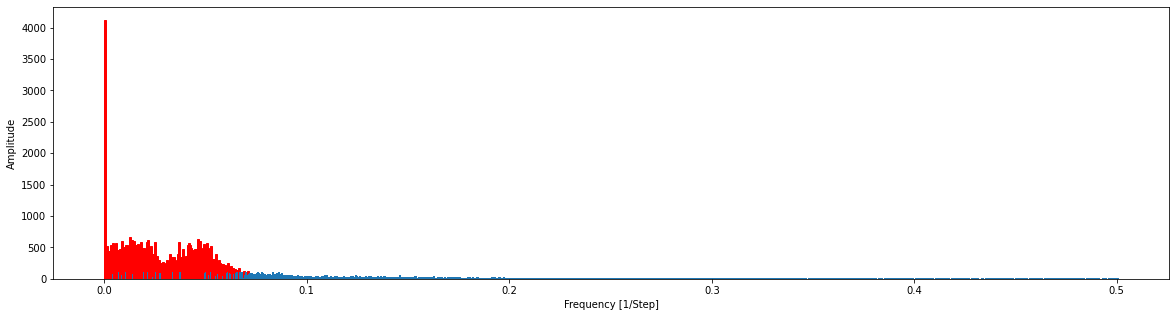


Average of the max freqs: 0.030634663466346638



In [17]:
s = ppo2_df['obs_4'].values
s_red = n_bins_fft(s, 500)

fig = px.line(y=s_red.real)
#this works for non negative signals fig = px.line(y=s_red.real**2 + s_red.imag**2)

fig.add_trace(go.Scatter(y=s, name='real'))
fig.show()

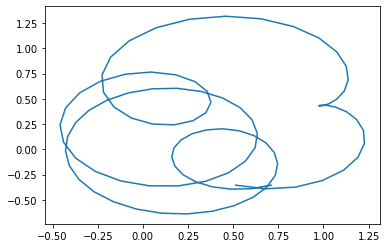

In [18]:
plt.plot(s_red.real[:100], s_red.imag[:100])
plt.show()

## Using a matrix profile to find repeating patterns

Ressources: 
- https://www.cs.ucr.edu/~eamonn/MatrixProfile.html
- https://towardsdatascience.com/introduction-to-matrix-profiles-5568f3375d90
- example code: https://github.com/matrix-profile-foundation/article-matrix-profile-intro/blob/master/Matrix%20Profile%20Example.ipynb
- https://github.com/matrix-profile-foundation/article-matrix-profile-intro

In [19]:
windows = [
    ('5 steps', 5),
    ('10 steps', 10),
    ('15 steps', 15),
    ('20 steps', 20),
    ('30 steps', 30),
    ('100 steps', 100),
]

profiles = get_mp(ppo2_df['obs_6'], windows, 'Total Time Steps', show=True)

## Decomposition into components using seasonal decomposition

Using `statsmodels.tsa.seasonal.seasonal_decompose`. ([Theory](https://otexts.com/fpp2/components.html))

The param `freq` needs to be chosen according to the underlying seasonality. From the Fourier analysis it was derived, the average frequency of `obs_4` is around `f=0.0306`.
$$T = 1/f$$ 
$$T = 1/0.0306 ≈ 33$$
For this model the period/ "seasonality" seems to be of around 33 steps. But experimenting suggests to use a `freq` 27.

[This post](https://stats.stackexchange.com/questions/285718/seasonal-decomposition) shows `freq` does not refer to the signal frequency!

In [20]:
# Import Data
time_ser = ppo2_df['obs_4'].values[:1000]

decompfreq = 27
# Multiplicative Decomposition 
# ValueError: Multiplicative seasonality is not appropriate for zero and negative values
# Therefore shift signal to +10
time_ser_shifted = time_ser + 10
result_mul = seasonal_decompose(time_ser_shifted, model='multiplicative', freq=decompfreq)

# Additive Decomposition
result_add = seasonal_decompose(time_ser, model='additive', freq=decompfreq)

# Plot with matplotlib
#plt.rcParams.update({'figure.figsize': (20,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
#result_add.plot().suptitle('Additive Decompose', fontsize=22)
#plt.show()

# Plot with plotly

fig = make_subplots(rows=4, cols=2, shared_xaxes=True, x_title='Time Steps')

# plot traces
fig.add_trace(go.Scatter(y=result_add.observed), row=1, col=1)
fig.add_trace(go.Scatter(y=result_add.trend), row=2, col=1)
fig.add_trace(go.Scatter(y=result_add.seasonal), row=3, col=1)
fig.add_trace(go.Scatter(y=result_add.resid), row=4, col=1)

fig.add_trace(go.Scatter(y=result_mul.observed), row=1, col=2)
fig.add_trace(go.Scatter(y=result_mul.trend), row=2, col=2)
fig.add_trace(go.Scatter(y=result_mul.seasonal), row=3, col=2)
fig.add_trace(go.Scatter(y=result_mul.resid), row=4, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)

fig.update_yaxes(title_text="Observed", row=1, col=2)
fig.update_yaxes(title_text="Trend", row=2, col=2)
fig.update_yaxes(title_text="Seasonal", row=3, col=2)
fig.update_yaxes(title_text="Residual", row=4, col=2)

# Update title and height
title = 'Additive Decomposition (left) and Multiplicative Decomposition (right, obs shifted to +10)'
fig.update_layout(title_text=title, height=700, width=1000, showlegend=False)

fig.show()

In this case both versions of the decomposition show the same results.